# Feature selection and feature engineering

This isn't based on a news article, exactly, it's from a paper. You can see the paper in `/data/`.

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline

import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression


pd.set_option("display.max_columns", 200)
pd.set_option("display.max_colwidth", 200)
%matplotlib inline

In [2]:
#saving file paths


# Reading in our data

## Every single person in a crash

We'll start by reading in the list of people who were involved in an accident.

**Call this dataframe `people`.**

In [3]:
#Only importing necessary columns to save memory
people=pd.read_csv("combined-person-data.csv", usecols=["SEX_CODE","INJ_SEVER_CODE","REPORT_NO","VEHICLE_ID"])

C:\Users\Anuja\AppData\Local\Programs\Python\Python37-32\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (26) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


How often did each severity of injury show up? (e.g. not injured, non-incapacitating injury, etc)

In [4]:
people["INJ_SEVER_CODE"].value_counts()

1    716806
2     82642
3     76801
4     10353
5      1681
Name: INJ_SEVER_CODE, dtype: int64

We're only interested in fatalities, so let's create a new `had_fatality` column for when people received a fatal injury.

**Confirm there were 1681 people with fatal injuries.**

In [5]:
people["had_fatality"]=people["INJ_SEVER_CODE"]
people.had_fatality=np.where(people.had_fatality==5,1,0)
people.had_fatality.value_counts()

0    886602
1      1681
Name: had_fatality, dtype: int64

In [6]:
people.columns

Index(['INJ_SEVER_CODE', 'REPORT_NO', 'SEX_CODE', 'VEHICLE_ID',
       'had_fatality'],
      dtype='object')

## Working on Features

### Starting our analysis

We're going to run a regression on the impact of being **male vs female on crash fatalities**. Prepare a dataframe called `train_df` with the appropriate information in it.

* **Tip:** What column(s) are your input, and what is your output? Aka independent and dependent variables
* **Tip:** You'll need to convert your input column into something numeric, I suggest using `.replace`
* **Tip:** We aren't interested in the "Unknown" sex - either filtering or `np.nan` + `.dropna()` might be useful ways to get rid of those columns

In [7]:
train_df=people[["SEX_CODE","had_fatality"]]
train_df["SEX_CODE"]=train_df["SEX_CODE"].replace("U",np.nan)

C:\Users\Anuja\AppData\Local\Programs\Python\Python37-32\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [8]:
train_df=train_df.dropna(subset=["SEX_CODE"])

In [9]:
train_df=pd.get_dummies(train_df.SEX_CODE, prefix="sex_").join(train_df).drop(columns=["sex__M","SEX_CODE"])

In [10]:
train_df.shape

(815827, 2)

Confirm that your `train_df` has two columns and 815,827 rows.

> **Tip:** If you have more rows, make sure you dropped all of the rows with Unknown sex.
>
> **Tip:** If you have more columns, make sure you only have your input and output columns.

In [11]:
#Creating my X and y variables
X=train_df[["sex__F"]]
y=train_df.had_fatality

### Run your regression

See the effect of sex on whether the person's injuries are fatal or not. After we train the regression, we can use my ✨favorite technique✨ to display features and their odds ratios:
    
```python
feature_names = X.columns
coefficients = clf.coef_[0]

pd.DataFrame({
    'feature': feature_names,
    'coefficient (log odds ratio)': coefficients,
    'odds ratio': np.exp(coefficients).round(4)
}).sort_values(by='odds ratio', ascending=False)
```

In [12]:
#Creating a model with the training dataset
model=LogisticRegression(C=1e9, solver="lbfgs",max_iter=4000)
results=model.fit(X, y)
log_coeff=model.coef_[0]
coeff=np.exp(log_coeff)

pd.DataFrame({
    "feature":X.columns,
    "odds_ratio":coeff,
    "intercept":model.intercept_
})


,feature,odds_ratio,intercept
0,sex__F,0.489285,-5.934307


### Use words to interpret this result

In [13]:
# The odds ratio is 0.489. This means that being female makes it ~50% less likely to die in an accident than being male.


## Adding more features

The actual crash data has more details - whether it was snowy/icy, whether it was a highway, etc. 

Read in `combined-crash-data.csv`, calling it **`crashes`**, and merge it with our people dataset. I'll save you a lookup: the `REPORT_NO` is what matches between the two.

In [14]:
#Only importing the necessary columns to save memory
crashes=pd.read_csv("combined-crash-data.csv", usecols=["REPORT_NO","SURF_COND_CODE"])

In [15]:
merged=crashes.merge(people, on="REPORT_NO")

### Examining more possible features

How often was it wet, dry, snowy, icy, etc? **What was the most common surfce condition?**

* **Tip:** We're interested in surface condition, _not_ road condition, _not_ weather condition

In [16]:
merged.SURF_COND_CODE.value_counts()

#Ans: Dry

2.00     619569
1.00     147803
0.00      30921
3.00       9418
4.00       9111
99.00      3616
6.03       1697
88.00      1064
5.00        447
7.01        258
9.88        141
8.05         36
Name: SURF_COND_CODE, dtype: int64

Do you feel that a **Dry** road condition should be the average of **Wet** and **Snow?**

In [17]:
#No - these are categorical variables

The answer to that should be *no*, which means we can't use this data as numeric data. We want a different coefficient for each of these - I want to know the impact of dry, the impact of wet, the impact of snow, all separately.

Start by **replacing each code with a proper description.** I'll even include them here:

* `00` - Not Applicable
* `01`	- Wet
* `02`	- Dry
* `03`	- Snow
* `04`	- Ice
* `05`	- Mud, Dirt, Gravel
* `06`	- Slush
* `07`	- Water (standing/moving)
* `08`	- Sand
* `09`	- Oil
* `88`	- Other
* `99`	- Unknown

But watch out, pandas read the column in as numbers so they might have come through a little differently than their codes.

In [18]:
merged.SURF_COND_CODE=merged.SURF_COND_CODE.replace({
    0.00:"Not Applicable",
    1.00:"Wet",
    2.00:"Dry",
    3.00:"Snow",
    4.00:"Ice",
    5.00:"Mud,Dirt,Gravel",
    6.00:"Slush",
    7.00:"Water",
    8.00:"Sand",
    9.00:"Oil",
    88.00:"Other",
    99.00:np.nan,
    6.03:"Other",
    7.01:"Other",
    8.05:"Other",
    9.88:"Other"  
})

In [19]:
merged.SURF_COND_CODE.value_counts()

Dry                619569
Wet                147803
Not Applicable      30921
Snow                 9418
Ice                  9111
Other                3196
Mud,Dirt,Gravel       447
Name: SURF_COND_CODE, dtype: int64

In [20]:
merged.columns

Index(['REPORT_NO', 'SURF_COND_CODE', 'INJ_SEVER_CODE', 'SEX_CODE',
       'VEHICLE_ID', 'had_fatality'],
      dtype='object')

Confirm you have 147,803 wet, and a few codes you can't understand, like `6.03` and `7.01`.

In [21]:
#Yes

Replace the codes you don't understand with `Other`.

In [22]:
#done above

Confirm you have 3,196 'Other'.

In [23]:
#Yes

## One-hot encoding

We're going to use `pd.get_dummies` to build a variable you'll call `surf_dummies`. Each surface condition should be a `0` or `1` as to whether it was that condition (dry, icy, wet, etc).

Use a `prefix=` so we know they are **surface** conditions.

You'll want to drop the column you'll use as the reference category.

**Before we do this: which column works best as the reference?**

Now build your `surf_dummies` variable.

In [24]:
#Directly joining merged
merged=pd.get_dummies(merged.SURF_COND_CODE, prefix="surf_dummies").drop(columns="surf_dummies_Not Applicable").join(merged)


Confirm your `surf_dummies` looks roughly like this:

|surface_Ice|Surce_Mud, Dirt, Gravel|surface_Not Applicable|...|surface_Wet|
|---|---|---|---|---|
|0|0|0|...|0|
|0|0|0|...|0|
|0|0|1|...|0|
|0|0|1|...|0|
|0|0|0|...|1|

## Another regression

Let's run another regression to see the impact of both **sex and surface condition** on fatalities.

### Build your `train_df`

To build your `train_df`, I recommend doing it either of these two ways. They both first select the important columns, then add in the one-hot encoded `surf_dummies` columns.

```python
train_df = pd.DataFrame({
    'col1': merged.col1,
    'col2': merged.col2,
    'col3': merged.col3,
})
train_df = train_df.join(surf_dummies)
train_df = train_df.dropna()
train_df.head()
```

or like this:

```python
train_df = train_df[['col1','col2','col3']].copy()
train_df = train_df.join(surf_dummies)
train_df = train_df.dropna()
train_df.head()
```

The second one is shorter, but the first one makes it easier to use comments to remove columns later.


In [25]:
train_df2=merged.copy()

train_df2["SEX_CODE"]=train_df2['SEX_CODE'].replace("U",np.nan)

train_df2=train_df2.dropna(subset=["SEX_CODE"])
train_df2=pd.get_dummies(train_df2.SEX_CODE, prefix="sex_").drop(columns=["sex__M"]).join(train_df2)


In [26]:
train_df2=train_df2.loc[:,"sex__F":"surf_dummies_Wet"].join(train_df2.loc[:,"had_fatality"])

In [27]:
train_df2.shape

(815843, 8)

In [28]:
train_df2.columns

Index(['sex__F', 'surf_dummies_Dry', 'surf_dummies_Ice',
       'surf_dummies_Mud,Dirt,Gravel', 'surf_dummies_Other',
       'surf_dummies_Snow', 'surf_dummies_Wet', 'had_fatality'],
      dtype='object')

### Run your regression and check your odds ratios

Actually no, wait, first - what kind of surface do you think will have the **highest fatality rate?**

In [29]:
#Dry

Confirm your `train_df` has 815,843 rows and 9 columns.

* **Tip:** When you run your regression, if you get an error about not knowing what to do with `U`, it's because you didn't convert your sex to numbers (or if you did, you didn't do it in your original dataframe)

In [30]:
X=train_df2.loc[:,"sex__F":"surf_dummies_Wet"]
y=train_df2["had_fatality"]
model=LogisticRegression(C=1e9, solver="lbfgs", max_iter=4000)
result=model.fit(X,y)

In [31]:
pd.DataFrame({
    "feature":X.columns,
    "co-eff":np.exp(result.coef_[0])
}).sort_values(by="co-eff", ascending=False)

,feature,co-eff
3,"surf_dummies_Mud,Dirt,Gravel",8.605214
4,surf_dummies_Other,5.110614
1,surf_dummies_Dry,2.994156
6,surf_dummies_Wet,2.551186
2,surf_dummies_Ice,1.611827
5,surf_dummies_Snow,1.465479
0,sex__F,0.488427


**Is this what you expected?** Why do you think this result might be the case?

In [32]:
# Yes, because the regression results show that the surface condition is more relevant in predicting fatalities as compared to 
##sex.

# No, because with value_counts,one would expect a dry surface to have caused more accidents. However, unlike probability,
## odds-ratio measures the likelihood of an accident occuring on a dry surface as compared to accidents not occuring on 
## a dry surface. Dry surface pops up in your value counts, simply because of the absolute number of accidents on dry surfaces.
## However, the regression shows that there are simply more cars being driven on dry surfaces. Accidents are more likely to
## occur on mud, dirt and gravel surfaces.

# More features: Vehicles

Maybe the car they're in is related to the car they were in. Luckily, we have this information - **read in `combined_vehicle_data` as `vehicles`.**

In [33]:
#Only importing a few columns to save memory
vehicles=pd.read_csv("combined-vehicle-data.csv", usecols=["VIN_NO","VEHICLE_ID","REPORT_NO","SPEED_LIMIT","BODY_TYPE_CODE"])

## Weights of those cars

The car weights are stored in **another file** since the info had to come from an API. I looked up the VINs - vehicle identification numbers - in a government database to try to get data for each of them.

**Read them and build a new dataframe that is both the vehicle data along with their weights.** You can call it `vehicles` since you don't need the original weightless vehicle data any more.

In [34]:
vehicles=pd.read_csv("vins_and_weights.csv").merge(vehicles, left_on="VIN", right_on="VIN_NO")

In [35]:
vehicles.shape

(534436, 10)

Confirm that your combined `vehicles` dataset should have 534,436 rows and 35 columns. And yes, that's less than we were working with before - you haven't combined it with the people/crashes dataset yet.

In [36]:
#Yes, except columns - I only imported a few

### Filter your data

We only want vehicles that are "normal" - somewhere between 1500 and 6000 pounds. Filter your vehicles to only include those in that weight range.

In [37]:
vehicles=vehicles[(vehicles["weight"]>=1500) & (vehicles["weight"]<=6000)]

Confirm that you have 532,370 vehicles in the dataset.

In [38]:
vehicles.shape
#Yes

(532370, 10)

## Add this vehicle information to your merged data

Now we'll have a dataframe that contains information on:

* The people themselves and their injuries
* The crash
* The vehicles

Every person came with a `VEHICLE_ID` column that is the vehicle they were in. You'll want to merge on that.

Confirm you have 99 columns and 616,212 rows. **That is a lot of possible features!**

In [39]:
merged_df2=merged.merge(vehicles, on="VEHICLE_ID", indicator=True)


## Another regression, because we can't get enough

Build another `train_df` and run another regression about **how car weight impacts the chance of fatalities**. You'll want to confirm that your dataset has 616,212 and 2 columns.

In [40]:
train_df3=merged_df2[["weight","had_fatality"]]

In [41]:
train_df3.shape
#Yes

(616212, 2)

In [42]:
X=train_df3[["weight"]]
y=train_df3["had_fatality"]
model=LogisticRegression(C=1e9, solver="lbfgs",max_iter=4000)
result=model.fit(X,y)

(array([1.66800e+04, 2.50090e+04, 6.77870e+04, 7.38000e+04, 1.00107e+05,
        1.72279e+05, 9.75380e+04, 5.71270e+04, 5.71900e+03, 1.66000e+02]),
 array([0.00092499, 0.0010059 , 0.0010868 , 0.00116771, 0.00124861,
        0.00132952, 0.00141042, 0.00149133, 0.00157223, 0.00165314,
        0.00173404]),
 <a list of 10 Patch objects>)

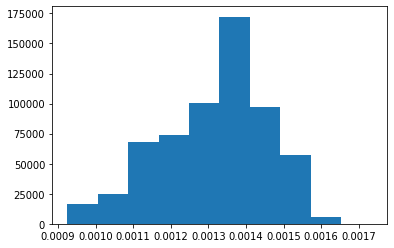

In [43]:
plt.hist(result.predict_proba(X)[:,1])

In [44]:
pd.DataFrame({
    "feature":X.columns,
    "co-eff":np.exp(result.coef_[0])
})


,feature,co-eff
0,weight,0.999853


**Can you translate that into plain English?** Remember weight is in **pounds**.

In [54]:
#For every pound increase in the weight of the car, the odds of a fatality occuring is 1% less. 

I feel like pounds isn't the best measure for something like this. Remember how we had to adjust percentages with AP and life expecntancy, and then change around the way we said things? It sounded like this:

> Every 10% increase in unemployment translates to a year and a half loss of life expectancy

Instead of every single pound, maybe we could do every... some other number of pounds? One hundred? One thousand?

**Run another regression with weight in thousands of pounds.** Get another odds ratio. Give me another sentence English.

In [55]:
#Note: 

X1=train_df3[["weight"]]
X1["weight"]=X1["weight"]/1000
y=train_df3["had_fatality"]

model=LogisticRegression(C=1e9, solver="lbfgs",max_iter=4000)
results=model.fit(X1,y)

pd.DataFrame({
    "feature":X1.columns,
    "co-eff":np.exp(results.coef_[0])
})

C:\Users\Anuja\AppData\Local\Programs\Python\Python37-32\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


,feature,co-eff
0,weight,0.863397


In [56]:
# Every thousand pounds heavier your car is increase translates to a 15% decrease in fatalities
##Yes

# Two-car accidents, struck and striker

Here's the thing, though: **it isn't just the weight of your car.** It's the weight of both cars! If I'm in a big car and I have a wreck with a smaller car, it's the smaller car that's in trouble.

To get that value, we need to do some **feature engineering**, some calculating of *new* variables from our *existing* variables.

We need to jump through some hoops to do that.

##  Two-car accidents

First we're going to count how many vehicles were in each accident. Since we're looking to compare the weight of two cars hitting each other, **we're only going to want crashes with only two cars.**

In [57]:
counted=vehicles.REPORT_NO.value_counts()
counted.head(10)

CB53480003      28
MDTA1229000H    26
AS0286000B      14
CE4636002C      14
MSP67460095     13
MSP6063006C     13
MSP63070049     12
AE5607002W      12
CC0237003W      12
DA3276000V      11
Name: REPORT_NO, dtype: int64

By using `.value_counts` I can see how many cars were in each crash, and now I'm going to filter to get a list of all of the ones with two vehicles.

In [58]:
two_car_report_nos = counted[counted == 2].index
two_car_report_nos

Index(['MSP56310050', 'AE5714002M', 'ADE459000Q', 'AE4538001N', 'MCP2582001R',
       'MSP6062003W', 'MSP0848000L', 'DA3871002M', 'MCP21980041',
       'MSP5656003Y',
       ...
       'ZJ0466000L', 'MSP6548002G', 'ADJ1970003', 'DA34130011', 'ZG09770004',
       'AE4424000J', 'HM0137000R', 'DA30510004', 'AE4851002R', 'AE4124007P'],
      dtype='object', length=137214)

And now we'll filter my vehicles so we only have those that were in two-vehicle crashes.

In [59]:
vehicles = vehicles[vehicles.REPORT_NO.isin(two_car_report_nos)]
vehicles.head()

,VIN,Make,Model,ModelYear,weight,BODY_TYPE_CODE,REPORT_NO,SPEED_LIMIT,VEHICLE_ID,VIN_NO
1,2G1WC5E37E1120089,CHEVROLET,IMPALA,2014,3618.0,2.00,ADJ268000T,25,ff6bfb11-c56a-495f-a750-5bcded4c1322,2G1WC5E37E1120089
2,5J6RE4H55AL053951,HONDA,CR-V,2010,3389.0,23.08,ADJ6580018,25,ff6d4345-edc5-46ad-b83e-4460694eae5f,5J6RE4H55AL053951
5,JTHCK262075010440,LEXUS,IS,2007,3527.0,2.00,AE57500027,30,b13fe432-8f69-442b-b4e1-471ae18de9eb,JTHCK262075010440
6,1N4AL2AP2CN414560,NISSAN,ALTIMA,2012,3189.0,2.00,AJ01220010,35,ff725f1b-501d-4191-b0a1-7e7867069f5d,1N4AL2AP2CN414560
8,5FNYF4H58DB014518,HONDA,PILOT,2013,4306.0,23.08,AE54190042,30,ff79ce6b-c568-4b4c-9c9d-90bf51be1fac,5FNYF4H58DB014518


### Struck and striker

To do the math correctly, we need both the risk of someone dying in the smaller car _and_ the risk of someone dying in the bigger car. To do this we need to separate our cars into two groups:

* The 'struck' vehicle: did the person die inside?
* The 'striker' vehicle: how much heavier was it than the struck car?

But we don't know which car was which, so we have to try out both versions - pretending car A was the striker, then pretending car B was the striker. It's hard to explain, but you can read `Pounds That Kill - The External Costs of Vehicle Weight.pdf` for more details on how it works.

In [60]:
cars_1 = vehicles.drop_duplicates(subset='REPORT_NO', keep='first')
cars_2 = vehicles.drop_duplicates(subset='REPORT_NO', keep='last')

In [61]:
cars_merged_1 = cars_1.merge(cars_2, on='REPORT_NO', suffixes=['_striker', '_struck'])
cars_merged_2 = cars_2.merge(cars_1, on='REPORT_NO', suffixes=['_striker', '_struck'])
vehicles_complete = pd.concat([cars_merged_1, cars_merged_2])
vehicles_complete.head()


,VIN_striker,Make_striker,Model_striker,ModelYear_striker,weight_striker,BODY_TYPE_CODE_striker,REPORT_NO,SPEED_LIMIT_striker,VEHICLE_ID_striker,VIN_NO_striker,VIN_struck,Make_struck,Model_struck,ModelYear_struck,weight_struck,BODY_TYPE_CODE_struck,SPEED_LIMIT_struck,VEHICLE_ID_struck,VIN_NO_struck
0,2G1WC5E37E1120089,CHEVROLET,IMPALA,2014,3618.0,2.00,ADJ268000T,25,ff6bfb11-c56a-495f-a750-5bcded4c1322,2G1WC5E37E1120089,JH4KA96624C006147,ACURA,RL,2004,3920.0,2.0,5,d6679a90-7ded-412d-91c1-9eedae56685c,JH4KA96624C006147
1,5J6RE4H55AL053951,HONDA,CR-V,2010,3389.0,23.08,ADJ6580018,25,ff6d4345-edc5-46ad-b83e-4460694eae5f,5J6RE4H55AL053951,JNKCV54E44M821620,INFINITI,G35,2004,3468.0,2.0,25,0ccc2fb4-d893-4e2e-afe5-51324a649bb4,JNKCV54E44M821620
2,JTHCK262075010440,LEXUS,IS,2007,3527.0,2.00,AE57500027,30,b13fe432-8f69-442b-b4e1-471ae18de9eb,JTHCK262075010440,1N6ED27Y91C303504,NISSAN,FRONTIER,2001,3137.0,20.0,30,2eb314a9-eef4-4c65-a413-209f919fcdb5,1N6ED27Y91C303504
3,1N4AL2AP2CN414560,NISSAN,ALTIMA,2012,3189.0,2.00,AJ01220010,35,ff725f1b-501d-4191-b0a1-7e7867069f5d,1N4AL2AP2CN414560,5NPEC4AC2BH142305,HYUNDAI,SONATA,2011,3199.0,2.0,35,d0e83934-f5ac-4aa9-ae73-c21b2618aec5,5NPEC4AC2BH142305
4,5FNYF4H58DB014518,HONDA,PILOT,2013,4306.0,23.08,AE54190042,30,ff79ce6b-c568-4b4c-9c9d-90bf51be1fac,5FNYF4H58DB014518,4T1BE32K25U986105,TOYOTA,CAMRY,2005,3450.0,2.0,30,503879b1-d51a-403c-98b5-195d890ad1de,4T1BE32K25U986105


## Put people in their cars

Which car was each person in? We'll assign that now.

In [62]:
merged2 = people.merge(vehicles_complete, left_on='VEHICLE_ID', right_on='VEHICLE_ID_struck')
merged2.head(3)

,INJ_SEVER_CODE,REPORT_NO_x,SEX_CODE,VEHICLE_ID,had_fatality,VIN_striker,Make_striker,Model_striker,ModelYear_striker,weight_striker,BODY_TYPE_CODE_striker,REPORT_NO_y,SPEED_LIMIT_striker,VEHICLE_ID_striker,VIN_NO_striker,VIN_struck,Make_struck,Model_struck,ModelYear_struck,weight_struck,BODY_TYPE_CODE_struck,SPEED_LIMIT_struck,VEHICLE_ID_struck,VIN_NO_struck
0,1,AB4313000X,F,b463eb20-2f01-4200-9d6f-b18888ce2593,0,2T2HA31U24C031048,LEXUS,RX,2004,3900.0,2.0,AB4313000X,25,3c8629d0-d524-47c1-bfbc-b18e07f3087e,2T2HA31U24C031048,2CNDL13F576252855,CHEVROLET,EQUINOX,2007,3776.0,2.00,25,b463eb20-2f01-4200-9d6f-b18888ce2593,2CNDL13F576252855
1,1,AB4313000X,F,3c8629d0-d524-47c1-bfbc-b18e07f3087e,0,2CNDL13F576252855,CHEVROLET,EQUINOX,2007,3776.0,2.0,AB4313000X,25,b463eb20-2f01-4200-9d6f-b18888ce2593,2CNDL13F576252855,2T2HA31U24C031048,LEXUS,RX,2004,3900.0,2.00,25,3c8629d0-d524-47c1-bfbc-b18e07f3087e,2T2HA31U24C031048
2,1,AB5218001Y,F,4dea42c3-e02c-4c6b-8ea0-c2f8c17f147f,0,1LNHM82W53Y644084,LINCOLN,TOWN CAR,2003,4000.0,2.0,AB5218001Y,25,057a3e63-3009-4d07-b956-78f53a0ca992,1LNHM82W53Y644084,5NMSG3AB9AH400386,HYUNDAI,SANTA FE,2010,3900.0,23.08,25,4dea42c3-e02c-4c6b-8ea0-c2f8c17f147f,5NMSG3AB9AH400386


# Add the crash details

You did this already! I'm going to do it for you. We're merging on `REPORT_NO_x` because there are so many `REPORT_NO` columns duplicated across our files that pandas started giving them weird names.

In [63]:
merged2 = merged2.merge(crashes, left_on='REPORT_NO_x', right_on='REPORT_NO')
merged2.head(3)

,INJ_SEVER_CODE,REPORT_NO_x,SEX_CODE,VEHICLE_ID,had_fatality,VIN_striker,Make_striker,Model_striker,ModelYear_striker,weight_striker,BODY_TYPE_CODE_striker,REPORT_NO_y,SPEED_LIMIT_striker,VEHICLE_ID_striker,VIN_NO_striker,VIN_struck,Make_struck,Model_struck,ModelYear_struck,weight_struck,BODY_TYPE_CODE_struck,SPEED_LIMIT_struck,VEHICLE_ID_struck,VIN_NO_struck,REPORT_NO,SURF_COND_CODE
0,1,AB4313000X,F,b463eb20-2f01-4200-9d6f-b18888ce2593,0,2T2HA31U24C031048,LEXUS,RX,2004,3900.0,2.0,AB4313000X,25,3c8629d0-d524-47c1-bfbc-b18e07f3087e,2T2HA31U24C031048,2CNDL13F576252855,CHEVROLET,EQUINOX,2007,3776.0,2.00,25,b463eb20-2f01-4200-9d6f-b18888ce2593,2CNDL13F576252855,AB4313000X,0.0
1,1,AB4313000X,F,3c8629d0-d524-47c1-bfbc-b18e07f3087e,0,2CNDL13F576252855,CHEVROLET,EQUINOX,2007,3776.0,2.0,AB4313000X,25,b463eb20-2f01-4200-9d6f-b18888ce2593,2CNDL13F576252855,2T2HA31U24C031048,LEXUS,RX,2004,3900.0,2.00,25,3c8629d0-d524-47c1-bfbc-b18e07f3087e,2T2HA31U24C031048,AB4313000X,0.0
2,1,AB5218001Y,F,4dea42c3-e02c-4c6b-8ea0-c2f8c17f147f,0,1LNHM82W53Y644084,LINCOLN,TOWN CAR,2003,4000.0,2.0,AB5218001Y,25,057a3e63-3009-4d07-b956-78f53a0ca992,1LNHM82W53Y644084,5NMSG3AB9AH400386,HYUNDAI,SANTA FE,2010,3900.0,23.08,25,4dea42c3-e02c-4c6b-8ea0-c2f8c17f147f,5NMSG3AB9AH400386,AB5218001Y,2.0


## Filter

We already filtered out vehicles by weight, so we don't have to do that again.

# Calculated features

I'm sure you forgot what all the features are, so we'll bring back whether there was a fatality or not

## Feature: Accident was fatal

In [64]:
merged2['had_fatality'] = (merged.INJ_SEVER_CODE == 5).astype(int)
merged2.had_fatality.value_counts()

0    333707
1       689
Name: had_fatality, dtype: int64

## Feature: Weight difference

**Remove everything missing weights for strikers or struck vehicles.** You might need to `merged.columns` to remind yourself what the column names are.

In [65]:
merged2=merged2.dropna(subset=["weight_striker","weight_struck"])

Confirm your dataset has roughly 335,000 rows.

In [66]:
merged2.shape

(334396, 26)

Create a new feature called `weight_diff` about how much heavier the striking car was compared to the struck car. **Make sure you've done the math correctly!**

In [67]:
merged2["weight_diff"]=merged2["weight_striker"]-merged2["weight_struck"]

### Feature adjustment

Make all of your weight columns in **thousands of pounds** instead of just in pounds. It'll help you interpret your results much better.

# Another regression!!!

**What is the impact of weight difference on fatality rate?** Create your `train_df`, drop missing values, run your regression, analyze your odds ratios.

In [68]:
merged2["weight_diff"]=merged2["weight_diff"]/1000
merged2=merged2.dropna(subset=["weight_diff","had_fatality"])
X=merged2[["weight_diff"]]
y=merged2["had_fatality"]
model=LogisticRegression(C=1e9, solver="lbfgs",max_iter=4000)
results=model.fit(X,y)
pd.DataFrame({
    "feature":X.columns,
    "co-eff":np.exp(results.coef_[0])
})

,feature,co-eff
0,weight_diff,0.993059


Please translate your odds ratio into plain English.

In [69]:
# For every thousand pounds increase in the marginal weight of the striker car, there is a ~61% increase in fatalities.

## Adding in more features

How about speed limit? That's important, right? We can add the speed limit of the striking vehicle with `SPEED_LIMIT_striker`.

In [70]:
merged2.columns

Index(['INJ_SEVER_CODE', 'REPORT_NO_x', 'SEX_CODE', 'VEHICLE_ID',
       'had_fatality', 'VIN_striker', 'Make_striker', 'Model_striker',
       'ModelYear_striker', 'weight_striker', 'BODY_TYPE_CODE_striker',
       'REPORT_NO_y', 'SPEED_LIMIT_striker', 'VEHICLE_ID_striker',
       'VIN_NO_striker', 'VIN_struck', 'Make_struck', 'Model_struck',
       'ModelYear_struck', 'weight_struck', 'BODY_TYPE_CODE_struck',
       'SPEED_LIMIT_struck', 'VEHICLE_ID_struck', 'VIN_NO_struck', 'REPORT_NO',
       'SURF_COND_CODE', 'weight_diff'],
      dtype='object')

In [71]:
X1=merged2[["weight_diff","SPEED_LIMIT_striker"]]
y=merged2["had_fatality"]
model=LogisticRegression(C=1e9, solver="lbfgs",max_iter=4000)
results=model.fit(X1,y)
pd.DataFrame({
    "feature":X1.columns,
    "co-eff":np.exp(results.coef_[0])
})

,feature,co-eff
0,weight_diff,0.993243
1,SPEED_LIMIT_striker,1.002355


Can you translate the speed limit odds ratio into plain English?

In [72]:
# The speed limit of the striker car has an effect on fatalty - 
##with every unit increase in the speed of the striker car, there is a ~5% increase in fatality.
##After accounting for the speed limit, an increase in the weight of the striker car by 1000 thousands results in a ~59% 
##increase in fatality.

### Feature engineering: Speed limits

Honestly, that's a pretty bad way to go about things. What's more fun is if we **translate speed limits into bins.**

First, we'll use `pd.cut` to assign each speed limit a category.

In [73]:
speed_bins = [-np.inf, 10, 20, 30, 40, 50, np.inf]
merged2['speed_bin'] = pd.cut(merged2.SPEED_LIMIT_struck, bins=speed_bins)
merged2[['SPEED_LIMIT_striker', 'speed_bin']].head(10)

,SPEED_LIMIT_striker,speed_bin
0,25,"(20.0, 30.0]"
1,25,"(20.0, 30.0]"
2,25,"(20.0, 30.0]"
3,25,"(20.0, 30.0]"
4,25,"(20.0, 30.0]"
5,5,"(-inf, 10.0]"
6,45,"(40.0, 50.0]"
7,45,"(40.0, 50.0]"
8,45,"(40.0, 50.0]"
9,45,"(40.0, 50.0]"


Then we'll one-hot encode around 20-30mph speed limits.

In [74]:
speed_dummies = pd.get_dummies(merged2.speed_bin, 
                               prefix='speed').drop('speed_(20.0, 30.0]', axis=1)
speed_dummies.head()

,"speed_(-inf, 10.0]","speed_(10.0, 20.0]","speed_(30.0, 40.0]","speed_(40.0, 50.0]","speed_(50.0, inf]"
0,0,0,0,0,0
1,0,0,0,0,0
2,0,0,0,0,0
3,0,0,0,0,0
4,0,0,0,0,0


## Running a regression

I like this layout for creating `train_df`, it allows us to easily add dummies and do a little replacing/encoding when we're building binary features like for sex.

> If the below gives you an error, it's because `SEX_CODE` is already a number. In that case, just remove `.replace({'M': 1, 'F': 0, 'U': np.nan })`.

In [75]:
# Start with our normal features
train_df4 = pd.DataFrame({
    'weight_diff': merged2.weight_diff,
    'sex': merged2.SEX_CODE.replace({'M': 1, 'F': 0, 'U': np.nan }),
    'had_fatality': merged2.had_fatality,
})
# Add the one-hot encoded features
train_df4 = train_df4.join(speed_dummies)
surf_dummies=merged[['surf_dummies_Dry', 'surf_dummies_Ice', 'surf_dummies_Mud,Dirt,Gravel','surf_dummies_Other', 'surf_dummies_Snow', 'surf_dummies_Wet']]
train_df4 = train_df4.join(surf_dummies)

# Drop missing values
train_df4 = train_df4.dropna()
train_df4.head()

,weight_diff,sex,had_fatality,"speed_(-inf, 10.0]","speed_(10.0, 20.0]","speed_(30.0, 40.0]","speed_(40.0, 50.0]","speed_(50.0, inf]",surf_dummies_Dry,surf_dummies_Ice,"surf_dummies_Mud,Dirt,Gravel",surf_dummies_Other,surf_dummies_Snow,surf_dummies_Wet
0,0.124,0.0,0,0,0,0,0,0,1,0,0,0,0,0
1,-0.124,0.0,0,0,0,0,0,0,1,0,0,0,0,0
2,0.100,0.0,0,0,0,0,0,0,1,0,0,0,0,0
3,-0.100,0.0,0,0,0,0,0,0,1,0,0,0,0,0
4,-0.100,1.0,0,0,0,0,0,0,1,0,0,0,0,0


In [76]:
X=train_df4.drop(columns="had_fatality")
y=train_df4["had_fatality"]
model=LogisticRegression(C=1e9, solver="lbfgs",max_iter=4000)
result=model.fit(X,y)

pd.DataFrame({
    "feature":X.columns,
    "coeff":np.exp(result.coef_[0])
}).sort_values(by="coeff", ascending=False)

,feature,coeff
10,surf_dummies_Other,11.385657
9,"surf_dummies_Mud,Dirt,Gravel",7.469658
7,surf_dummies_Dry,3.607917
12,surf_dummies_Wet,3.037426
8,surf_dummies_Ice,2.971510
11,surf_dummies_Snow,1.542611
5,"speed_(40.0, 50.0]",1.071110
2,"speed_(-inf, 10.0]",0.997230
0,weight_diff,0.987504
1,sex,0.946173


Describe the impact of the different variables in simple language. What has the largest impact?

In [77]:
# Surface variables have a greater impact on fatality than non-surface variables. After controlling for factors
# such as the speed and weight of the car that struck, and the sex of the driver, the odds of an accident
# occuring on a mud, dirt and gravel surface was double the odds of a fatality occuring in a surface marked as not applicable.

## Now you pick the features

Up above you have examples of:

* Creating features from numbers (speed limits)
* Creating features from 0/1 (sex)
* Creating features from binning numbers that are one-hot encoded (speed limit bins - `speed_bins`)
* Creating features from categories that are one-hot encoded (surface - `surf_dummies`

What else do you think matters? Try to plug in more features and see if you can get anything interesting.

> * **Hot tip:** The funniest/most interesting thing feature you can add is also the dumbest. Ask me about it in #algorithms if you end up getting down here.

In [78]:
# Looking at whether passenger cars have greater odds of fatalities - The model shows it doesn't - 
## being in a passenger car might be more safe than being in another vehicle

merged_df2.BODY_TYPE_CODE=merged_df2.BODY_TYPE_CODE.replace({
    2.00:"Passenger Car"
})

merged_df2.BODY_TYPE_CODE=np.where(merged_df2.BODY_TYPE_CODE!="Passenger Car", 0,1)

In [79]:
add=merged_df2[["BODY_TYPE_CODE","had_fatality"]]
add=add.rename(columns={
    "BODY_TYPE_CODE":"Passenger_vechicle"
})

In [80]:
X=add.drop(columns="had_fatality")
y=add["had_fatality"]
model=LogisticRegression(C=1e9, solver="lbfgs",max_iter=4000)
result=model.fit(X,y)

pd.DataFrame({
    "feature":X.columns,
    "coeff":np.exp(result.coef_[0])
}).sort_values(by="coeff", ascending=False)

,feature,coeff
0,Passenger_vechicle,0.86722


### The End!